# Recurrent Neural Networks - Using LSTM for writing like Shakespeare


A similar (but more complicated) task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in ths sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 

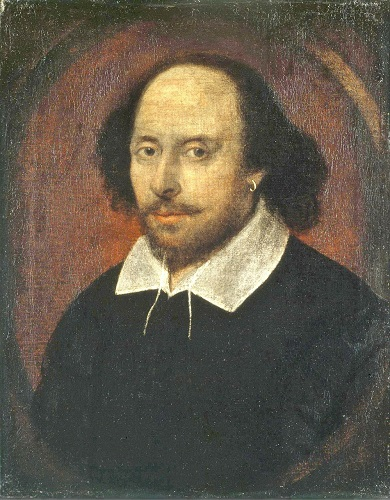

We have implemented a Shakespeare poem generator with Keras. Run the following cell to load the required packages and models. This may take a few minutes. 

The RNN-Shakespeare model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 


In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys
import io

Using TensorFlow backend.


# Loading text from poem called **"The Sonnets"**. 

In [2]:
text = io.open('../input/RnnDS/shakespeare.txt', encoding='utf-8').read().lower()
print('corpus length:', len(text))

Tx = 40
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print('number of unique characters in the corpus:', len(chars))

corpus length: 94275
number of unique characters in the corpus: 38


# Creating training set

Create a training set by scanning a window of size Tx over the text corpus, with stride 3.
   
    Arguments:
    text -- string, corpus of Shakespearian poem
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels

In [4]:
def build_data(text, Tx = 40, stride = 3):  
    X = []
    Y = []
    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    return X, Y

In [9]:
X, Y = build_data(text, Tx, stride = 3)
print('number of training examples:', len(X))
X[0:100],Y[0:100]


number of training examples: 31412


(['the sonnets\n\nby william shakespeare\n\nfro',
  ' sonnets\n\nby william shakespeare\n\nfrom f',
  'nnets\n\nby william shakespeare\n\nfrom fair',
  'ts\n\nby william shakespeare\n\nfrom fairest',
  '\nby william shakespeare\n\nfrom fairest cr',
  ' william shakespeare\n\nfrom fairest creat',
  'lliam shakespeare\n\nfrom fairest creature',
  'am shakespeare\n\nfrom fairest creatures w',
  'shakespeare\n\nfrom fairest creatures we d',
  'kespeare\n\nfrom fairest creatures we desi',
  'peare\n\nfrom fairest creatures we desire ',
  're\n\nfrom fairest creatures we desire inc',
  '\nfrom fairest creatures we desire increa',
  'om fairest creatures we desire increase,',
  'fairest creatures we desire increase,\nth',
  'rest creatures we desire increase,\nthat ',
  't creatures we desire increase,\nthat the',
  'reatures we desire increase,\nthat thereb',
  'tures we desire increase,\nthat thereby b',
  'es we desire increase,\nthat thereby beau',
  "we desire increase,\nthat thereby bea

# Vectorization
Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))

In [10]:
def vectorization(X, Y, n_x, char_indices, Tx = 40):
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, n_x), dtype=np.bool)
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1
    return x, y 

In [11]:
x, y = vectorization(X, Y, n_x = len(chars), char_indices = char_indices) 
print("x=",x.shape,"y=",y.shape)

x= (31412, 40, 38) y= (31412, 38)


# Load Model

In [12]:
model = load_model('../input/RnnDS/model_data/model_shakespeare_kiank_350_epoch.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40, 38)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 128)           85504     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 38)                4902      
_________________________________________________________________
activation_3 (Activation)    (None, 38)                0         
Total para

# Train

Let's train the model for one more epoch. When it finishes training for an epoch---this will also take a few minutes---you can run `generate_output`, which will prompt asking you for an input (`<`40 characters). The poem will start with your sentence, and our RNN-Shakespeare will complete the rest of the poem for you! For example, try "Forsooth this maketh no sense " (don't enter the quotation marks). Depending on whether you include the space at the end, your results might also differ--try it both ways, and try other inputs as well. 


In [14]:
hist=model.fit(x, y, batch_size=128, epochs=1)

Epoch 1/1
31412/31412 [==============================] - 68s 2ms/step - loss: 2.7308


In [40]:
seed=0

In [53]:
seed=seed+1
np.random.seed(seed)
usr_input='the sonnets\n\nby william shakespeare\n\nfro'
sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower() 
x_pred = np.zeros((1, Tx, len(chars)))

for t, char in enumerate(sentence):
    if char != '0':
        x_pred[0, t, char_indices[char]] = 1.

preds = model.predict(x_pred, verbose=0)[0]

indices_char[np.argmax(preds)]

vpreds = np.asarray(preds).astype('float64')
vpreds = np.log(vpreds) 
exp_preds = np.exp(vpreds)
vpreds = exp_preds / np.sum(exp_preds)
np.random.multinomial(1, preds, 1).argmax()
np.random.choice(range(len(chars)), p = vpreds.ravel())
vpreds,preds,np.sum(exp_preds)

(array([6.62912480e-04, 1.05626096e-01, 5.69643437e-06, 2.20348237e-04,
        3.23191298e-05, 1.46728844e-06, 1.08205408e-03, 9.95106683e-06,
        1.31526522e-04, 1.21709842e-05, 1.48291252e-05, 1.48671107e-04,
        2.86857357e-04, 1.92565337e-03, 5.98623393e-05, 5.18835484e-04,
        3.18893048e-04, 3.10773301e-03, 1.70677546e-04, 5.44778434e-05,
        6.75009632e-05, 1.85438870e-05, 4.89890212e-06, 2.19873519e-03,
        8.20190049e-01, 8.24969797e-03, 1.23458143e-03, 7.97879161e-04,
        6.49595659e-07, 9.75852339e-03, 8.89116128e-03, 4.25047835e-03,
        2.09726760e-03, 2.30652710e-04, 2.73789681e-02, 7.24593817e-06,
        2.31035542e-04, 1.09867048e-06]),
 array([6.62912498e-04, 1.05626099e-01, 5.69643453e-06, 2.20348244e-04,
        3.23191307e-05, 1.46728848e-06, 1.08205411e-03, 9.95106711e-06,
        1.31526525e-04, 1.21709845e-05, 1.48291256e-05, 1.48671112e-04,
        2.86857365e-04, 1.92565343e-03, 5.98623410e-05, 5.18835499e-04,
        3.18893057e-04

# Use Prediction to Generate Poem

In [38]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p = probas.ravel())
    return out
    #return np.argmax(probas)
    


def generate_output(usr_input):
    generated = ''
    #sentence = text[start_index: start_index + Tx]
    #sentence = '0'*Tx
    if (usr_input==""):
        usr_input = input("Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: ")
    # zero pad the sentence to Tx characters.
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds) #sample(preds, temperature = 1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

# Test

In [39]:
generate_output("Forsooth this maketh no sense ")



Here is your poem: 

Forsooth this maketh no sense the show,
that in thes with my sorrese then the say,
that i say the summer's dain the world,
and me the shall of the be art be and beart,
and then i am aster the show andes be and,
and then i am aster the show and be and be,
and thein of the besury me the dearned,
that i as my his borded thee my to sell thanged,
and thes besure the same the sweet be to be,
and thes be forted be art with storn my s